<a href="https://colab.research.google.com/github/haleywis/OPTI556/blob/main/556_HW2_Wiskoski_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OPTI-556: Computational Imaging**  
# Haley Wiskoski  
Homework #1 - Part 3
Due: Tuesday September 7th, 2021

## Libraries

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy import interpolate as interp
from scipy.special import expit
from google.colab import files
import imageio
from PIL import Image
import cv2
!pip install visualkeras
import visualkeras
!pip install rawpy
import rawpy

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
tf.experimental_relax_shapes=True

     |████████████████████████████████| 795 kB 2.8 MB/s 
     |████████████████████████████████| 1.7 MB 2.8 MB/s 


## Demosaicing with Neural Processing

### Training Data Set

In [3]:
!wget --no-check-certificate -r -nH --cut-dirs=2 --no-parent --reject="index.html*" https://www.math.purdue.edu/~lucier/PHOTO_CD/D65_TIFF_IMAGES/

--2021-09-28 08:26:25--  https://www.math.purdue.edu/~lucier/PHOTO_CD/D65_TIFF_IMAGES/
Resolving www.math.purdue.edu (www.math.purdue.edu)... 128.210.40.74
Connecting to www.math.purdue.edu (www.math.purdue.edu)|128.210.40.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5974 (5.8K) [text/html]
Saving to: ‘D65_TIFF_IMAGES/index.html.tmp’

D65_TIFF_IMAGES/ind 100%[===================>]   5.83K  --.-KB/s    in 0s      

2021-09-28 08:26:26 (189 MB/s) - ‘D65_TIFF_IMAGES/index.html.tmp’ saved [5974/5974]

Loading robots.txt; please ignore errors.
--2021-09-28 08:26:26--  https://www.math.purdue.edu/robots.txt
Reusing existing connection to www.math.purdue.edu:443.
HTTP request sent, awaiting response... 404 Not Found
2021-09-28 08:26:26 ERROR 404: Not Found.

Removing D65_TIFF_IMAGES/index.html.tmp since it should be rejected.

--2021-09-28 08:26:26--  https://www.math.purdue.edu/~lucier/PHOTO_CD/D65_TIFF_IMAGES/?C=N;O=D
Reusing existing connection to www.math.p

(-0.5, 3071.5, 2047.5, -0.5)

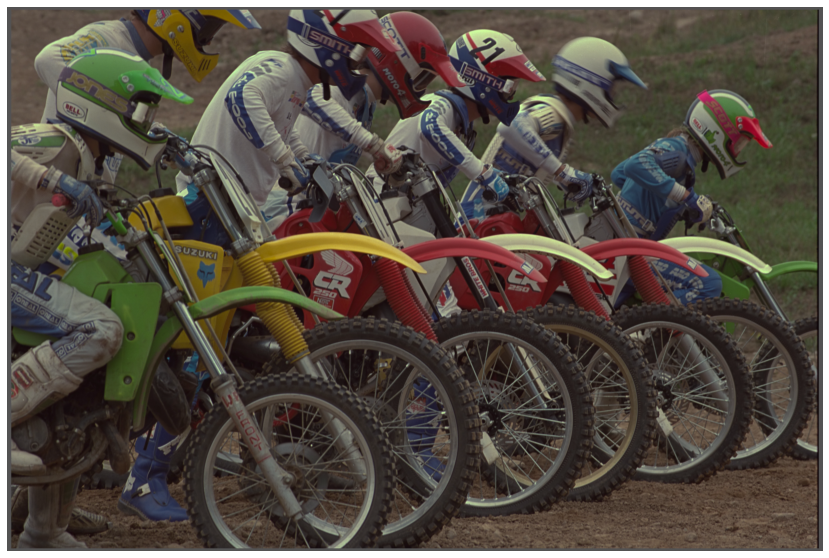

In [4]:
im=np.zeros((24,2048,3072,3))
for pop in range(1,10):
  fileN="D65_TIFF_IMAGES/IMG000"+np.str(pop)+".tif"
  imm = Image.open(fileN)
  imm=np.array(imm)
  w,h,c =imm.shape
  if w>h:
    imm=imm.transpose(1,0,2)
  im[pop-1,:,:,:]=np.array(imm)/255.
for pop in range(10,25):
  fileN="D65_TIFF_IMAGES/IMG00"+np.str(pop)+".tif"
  imm = Image.open(fileN)
  imm=np.array(imm)
  w,h, c =imm.shape
  if w>h:
    imm=imm.transpose(1,0,2)
  im[pop-1,:,:,:]=np.array(imm)/255.

plt.imshow(im[4,:,:,:])
plt.axis('off')

### Color Sampling Functions
Here we create the filter array for Bayer color sampling, which we then use to create a network that transforms 32x32 color images into 16x16x4 sample arrays. 

In [8]:
def bayerCFA(shape,dtype='none'):
    kernel = np.array([[[1,0,0],[0,0,0]],[[0,0,0],[0,0,0]]])
    kernel = np.stack((kernel,np.array([[[0,0,0],[0,1,0]],[[0,0,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,1,0],[0,0,0]]]),np.array([[[0,0,0],[0,0,0]],[[0,0,0],[0,0,1]]] )),axis=-1)
    return kernel

inputs = layers.Input(shape=(None,None,3))
cfa = layers.Conv2D(4, (2,2), (2,2), use_bias=False, input_shape=(32,32,3),kernel_initializer=bayerCFA)(inputs)
cfaSample=Model(inputs,cfa)

### Creation of Training Blocks
In this portion, we use the first 20 images of the dataset to generate 7680 training images. The last 4 images will be used to generate 1536 test images. 

In [9]:
trainS=7680
testS=1536
xtrain=np.zeros((trainS,64,64,4))
ytrain=np.zeros((trainS,128,128,3))
xtest=np.zeros((testS,64,64,4))
ytest=np.zeros((testS,128,128,3))
for imc in range(20):
  for row in range(16):
    for column in range(24):
      ytrain[(imc*20*16+row*24+column),:,:,:]=im[imc,(row*128):((row+1)*128),(column*128):((column+1)*128):,:]
      xtrain[(imc*20*16+row*24+column),:,:,:]=cfaSample.predict(im[imc:(imc+1),(row*128):((row+1)*128),(column*128):((column+1)*128):,:])
for imc in range(4):
  for row in range(16):
    for column in range(24):
      ytest[(imc*20*16+row*24+column),:,:,:]=im[imc+20,(row*128):((row+1)*128),(column*128):((column+1)*128):,:]
      xtest[(imc*20*16+row*24+column),:,:,:]=cfaSample.predict(im[(imc+20):(imc+21),(row*128):((row+1)*128),(column*128):((column+1)*128):,:])
xtrain=np.reshape(xtrain, (len(xtrain), 64, 64, 4))
ytrain=np.reshape(ytrain, (len(ytrain), 128, 128, 3))
xtest=np.reshape(xtest, (len(xtest), 64, 64, 4))
ytest=np.reshape(ytest, (len(ytest), 128, 128, 3))
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
test_dataset = tf.data.Dataset.from_tensor_slices((xtest,ytest))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Network Architecture


In [10]:
inputs = layers.Input(shape=(None,None,4))
# Encoder
x1 = layers.Conv2D(16, (2, 2), strides=2, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2))(x1)
x2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x3 = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x2)
x = layers.MaxPooling2D((2, 2))(x3)
x = layers.Conv2D(128, (3, 3),  activation="relu", padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,x2])
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,x1])
x = layers.Conv2DTranspose(4, (3, 3), strides=2, activation="relu", padding="same")(x)
x=layers.add([x,inputs])
x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="linear", padding="same")(x)

# Autoencoder
demosaic = Model(inputs, x)
demosaic.compile(optimizer="adam", loss="mean_squared_error")
demosaic.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 272         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 1 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 4640        max_pooling2d[0][0]              
____________________________________________________________________________________________

### Training the Model

In [11]:
demosaic.fit(train_dataset,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=test_dataset
)

Epoch 1/20
240/240 [==============================] - 60s 244ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 2/20
240/240 [==============================] - 59s 244ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 3/20
240/240 [==============================] - 58s 243ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/20
240/240 [==============================] - 58s 243ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/20
240/240 [==============================] - 58s 244ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/20
240/240 [==============================] - 59s 245ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/20
240/240 [==============================] - 59s 247ms/step - loss: 8.2496e-04 - val_loss: 0.0011
Epoch 8/20
240/240 [==============================] - 59s 245ms/step - loss: 6.5549e-04 - val_loss: 8.9590e-04
Epoch 9/20
240/240 [==============================] - 58s 244ms/step - loss: 5.0882e-04 - val_loss: 6.0053e-04
Epoch 10/20
240/240 [==============================] 

In [17]:
demosaic.save("demosaic")
!tar -czvf demosaic.tar.gz demosaic/
files.download('demosaic.tar.gz')

INFO:tensorflow:Assets written to: demosaic/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


demosaic/
demosaic/assets/
demosaic/variables/
demosaic/variables/variables.data-00000-of-00001
demosaic/variables/variables.index
demosaic/keras_metadata.pb
demosaic/saved_model.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load the Trained Model 
At this point, we will load the trained model and use it on a few sample images. We will compare the results with those of openCV's demosaicing algorithm.

In [18]:
!wget --no-check-certificate --content-disposition 'https://github.com/haleywis/OPTI556/blob/main/demosaic.tar.gz'
!tar -xvf demosaic.tar.gz


--2021-09-28 09:32:16--  https://github.com/haleywis/OPTI556/blob/main/demosaic.tar.gz
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘demosaic.tar.gz.3’

demosaic.tar.gz.3       [ <=>                ] 125.47K  --.-KB/s    in 0.1s    

2021-09-28 09:32:17 (1.07 MB/s) - ‘demosaic.tar.gz.3’ saved [128477]

demosaic/
demosaic/assets/
demosaic/variables/
demosaic/variables/variables.data-00000-of-00001
demosaic/variables/variables.index
demosaic/keras_metadata.pb
demosaic/saved_model.pb
